# Digits Recognizer Kaggle Competition

I'll use a convolutional neural network with dropout to classify the handwritten digits dataset.

## Imports

Python software packages we use in this notebook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from random import choice

%matplotlib inline

## Hyperparameters

Change these to determine the hyperparameter configuration of the convolutional neural network and the data-preprocessing.

In [2]:
# determines training / validation split
TRAIN_SIZE = 37000

# neural network learning rate
LEARNING_RATE = 1e-4

# minibatch size
BATCH_SIZE = 50

# dropout probability
DROPOUT = 0.5

# number of training epochs
EPOCHS = 10000

## Data Pre-processing

The training dataset has 42,000 rows and 784 columns, where each row corresponds to a single image of a digit, and each column corresponds to the value of a pixel intensity in an image of a digit; i.e., each column is a "feature" of the digit representation. The test dataset has some 28,000 rows and again, 784 columns. 

The datapoints have been flattened from shape (28, 28) to (784,), but we'll reshape these later in order to make use of the image-filtering capacity of convolutional neural networks.

In [3]:
# read in training data
train = pd.read_csv('../data/train.csv')

In [4]:
# store training dataset as NumPy arrays
X_train = np.array(train.drop('label', axis=1))
y_train = np.array(train['label'])

# normalize pixel values
X_train = np.multiply(X_train, 1.0 / 255.0)

# function to convert labels to one-hot vectors
def dense_to_one_hot(labels_dense):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * 10
    labels_one_hot = np.zeros((num_labels, 10))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# use the function!
y_train = dense_to_one_hot(y_train).astype(np.int)

# split into training / validation sets (let's use a 37,000 / 5,000 split)
X_train, X_valid = X_train[:TRAIN_SIZE], X_train[TRAIN_SIZE:]
y_train, y_valid = y_train[:TRAIN_SIZE], y_train[TRAIN_SIZE:]

# get shapes of training, validation, and test datasets
print 'training data shapes:', X_train.shape, y_train.shape
print 'validation data shapes:', X_valid.shape, y_valid.shape

# get size, shape of dataset images
image_size = X_train[0,:].shape[0]
print 'image size:', image_size
image_side_length = int(np.sqrt(X_train[0,:].shape[0]))
print 'image shape:', image_side_length, 'x', image_side_length

training data shapes: (37000, 784) (37000, 10)
validation data shapes: (5000, 784) (5000, 10)
image size: 784
image shape: 28 x 28


## Displaying Digit Images

A simple function (borrowed from https://www.kaggle.com/kakauandme/digit-recognizer/tensorflow-deep-nn) to display a digit image. We need to reshape from (784,) to (28, 28) so we have the correct _human friendly_ representation. 

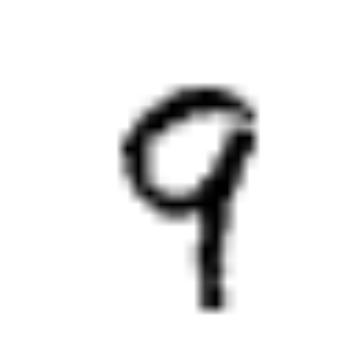

In [5]:
# display image
def display(img):    
    # (784) => (28,28)
    img = img.reshape((28,28))
    
    plt.axis('off')
    plt.imshow(img, cmap=cm.binary)

# output image     
display(choice(X_train))

## Building the Tensorflow Computation Graph

Tensorflow does much of its numerical computation and book-keeping outside of Python. Tensorflow allows us to build an entire graph of interacting operations, and run the whole workflow in a separate process all at once.

I define several helper functions for creating weight / bias variables and convolution and pooling operations.

Since we're using ReLUs (rectified linear units, defined by $f(x) = max(0, x)$), we initialize weight vectors with a bit of positive noise to avoid "dead neurons"; i.e., units whose activations fall below zero and never becoem positive again.

We'll use zero-padded convolutions so that the output is the same size as the input. The convolution stride in this case is 1 (subject to change). Generally, convolutional layers are responsible for extracting different levels of features from the input data or the output from a previous layer. In digit recognition, low-level features might consist of (among other things) edges (black to white) of various orientation, and higher-level features might consist of sub-shapes characteristic of certain digits, or even canonical or averaged representations of an entire digit class.

We use max-pooling over 2x2 blocks (subject to change). This operation is used to down-sample, or reduce the dimensionality of, the output of a previous layer. Max-pooling keeps only the maximum value from each (2x2) block of its input.

In [6]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# bias initialization
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# convolution operation
def conv2d(x, W):
    # using TensorFlow's conv2d operation with above mentioned parameters
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# max-pooling operation
def max_pool_2x2(x):
    # using TensorFlow's max_pool operation
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Any neural network can be used as a layer in a larger neural network (since a "layer" need only be a differentiable operation; this holds for entire NNs). This means that the output for one network can be used as the input for another network. This compositional approach to building neural networks is the reason for the now-popular moniker "deep learning".

In this notebook, we'll implement a convolutional neural network with two convolutional layers and two max-pooling layers interweaved, a fully-connected layer, and then a logistic regression layer trained on the activations output from the fully-connected layer.

Let's define variables for NN input, output:

In [7]:
x = tf.placeholder('float', shape=[None, image_size])
y_ = tf.placeholder('float', shape=[None, 10])

The first layer is a convolution layer followed by max-pooling. The convolution computes 32 features for each 5x5 in the image (with strides of 1). Thus, its weights tensor has shape [5, 5, 1, 32], where the first two dimensions are patch size, the second is the number of input channels (1 corresponds to the fact that the image is grayscale), and the last is the number of output channels or filters. There is also a bias vector with a single component for each output channel.

To apply the layer, we reshape the input data into a 4-dimensional tensor with the first dimension corresponding to the number of images, the second and third to the image width and height, and the last to the number of input channels (On the image input, its shape becomes [37,000, 28, 28, 1]).

After the convolution operation, the max-pooling operation reduces the size of the output (of each channel) from 28x28 to 14x1 (of which there are 32, for an output tensor of shape [37,000, 14, 14, 32]).

In [8]:
# 1st convolution layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# reshaping input (-1 corresponds to arbitrary dimensionality)
image = tf.reshape(x, [-1, 28, 28, 1])
# print image.get_shape() gives (?, 28, 28, 1)

# convolution hidden layer
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)

# max-pooling hidden layer
h_pool1 = max_pool_2x2(h_conv1)

# Prepare for visualization
# display 32 features in a (4 x 8) grid
layer1 = tf.reshape(h_conv1, (-1, 28, 28, 4, 8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, 28*4, 28*8))

The second layer has 64 features for each 5x5 input patch (again, strided by 1). Therefore, its weight tensor has shape [5, 5, 32, 64], where the first two dimensions are patch size, the third is the number of input channels, and the fourth is the number of output channels. Again, there is a bias vector which has a single component for each output channel.

In [9]:
# 2nd convolution layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# convolution hidden layer
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# max-pooling hidden layer
h_pool2 = max_pool_2x2(h_conv2)

# Prepare for visualization
# display 64 features in a (4 x 16) grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))

The image size has been reduced to 7x7 by the last max-pooling layer, and so the shape of the data tensor is now [37,000, 7, 7, 64]. Now, we add a fully-connected layer of 1,024 neurons to do processing on the entire current feature representation of the image.

In [10]:
# fully-connected layer
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

# flattening output of previous max-pooling layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# fully-connected hidden layer
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

We apply dropout before the read-out layer in an effort to prevent over-fitting to training data:

In [11]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we attach a logisic regression layer to the output of the previous fully-connected layer:

In [12]:
# readout layer / softmax
W_out = weight_variable([1024, 10])
b_out = bias_variable([10])

# output (softmax)
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_out) + b_out)

We use the cross-entropy loss to evaluate network performance, and use the ADAM optimizer to minimize this loss:

In [13]:
# loss function
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

# optimization function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from test data, the element with the highest probability will be picked from the one-hot vector representation.

In [14]:
# prediction function
predict = tf.argmax(y,1)

## Train, Validate, and Predict

Now that we've defined our neural network architecture, we can train and validate our model, and compile a prediction file for the Kaggle competition.

I define a helper function for doing mini-batch-wise training (stochastic mini-batch training), which is cheaper, faster, and gives similar results than using the entire training dataset per step of network training.

In [15]:
epochs_completed = 0
index_in_epoch = 0
num_examples = X_train.shape[0]

# serve up data by minibatch
def next_batch():
    batch_size = BATCH_SIZE
    
    global X_train
    global y_train
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all training data have been already used, reorder it randomly   
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return X_train[start:end], y_train[start:end]

Now, when all operations for every variable is defined in the TensorFlow graph, all computations will be performed outside the Python environment.

In [16]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init)

In each step of the loop, we get a minibatch of training data, which we feed into the computation graph to replace the placeholders "x", "y\_", and "dropout". We check training / validation set accuracy every once in a while on an incoming minibatch. 

In [ ]:
# visualization variables
train_accuracies, validation_accuracies, X_range = [], [], []
display_step = 1

for i in range(EPOCHS):
    # get a new training minibatch
    X_batch, y_batch = next_batch()
        
    # check progress on certain epochs
    if i % display_step == 0 or (i + 1) == EPOCHS:
        # get training accuracy on incoming minibatch
        training_accuracy = accuracy.eval(feed_dict={x : X_batch, y_ : y_batch, keep_prob : 1.0})
        
        # get validation accuracy on incoming minibatch
        validation_accuracy = accuracy.eval(feed_dict={x : X_valid[0:BATCH_SIZE], y_ : y_valid[0:BATCH_SIZE], keep_prob : 1.0})
        
        print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(training_accuracy, validation_accuracy, i))
            
        validation_accuracies.append(validation_accuracy)
        
        train_accuracies.append(training_accuracy)
        X_range.append(i)
        
        # increase display step
        if i % (display_step*10) == 0 and i:
            display_step *= 10
            
    # train on minibatch
    sess.run(train_step, feed_dict={x : X_batch, y_ : y_batch, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.16 / 0.10 for step 0
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 1
training_accuracy / validation_accuracy => 0.06 / 0.24 for step 2
training_accuracy / validation_accuracy => 0.12 / 0.28 for step 3
training_accuracy / validation_accuracy => 0.18 / 0.26 for step 4
training_accuracy / validation_accuracy => 0.32 / 0.28 for step 5
training_accuracy / validation_accuracy => 0.12 / 0.26 for step 6
training_accuracy / validation_accuracy => 0.16 / 0.30 for step 7
training_accuracy / validation_accuracy => 0.20 / 0.22 for step 8
training_accuracy / validation_accuracy => 0.18 / 0.24 for step 9
training_accuracy / validation_accuracy => 0.22 / 0.22 for step 10
training_accuracy / validation_accuracy => 0.34 / 0.50 for step 20
training_accuracy / validation_accuracy => 0.60 / 0.54 for step 30
training_accuracy / validation_accuracy => 0.68 / 0.54 for step 40
training_accuracy / validation_accuracy => 0.74 / 0.68 for step 50
train

validation_accuracy => 0.9892


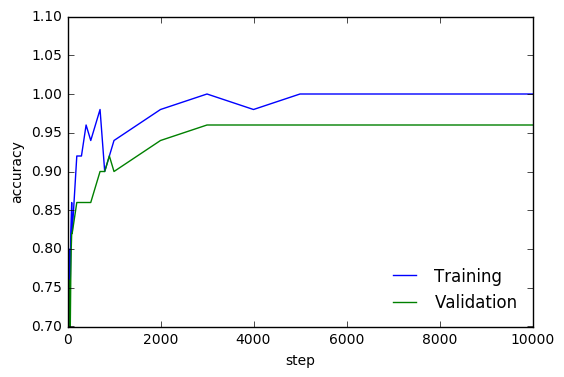

In [18]:
# check final accuracy on validation set  

validation_accuracy = accuracy.eval(feed_dict={x : X_valid, y_ : y_valid, keep_prob: 1.0})

print 'validation_accuracy => %.4f' % validation_accuracy

plt.plot(X_range, train_accuracies,'-b', label='Training')
plt.plot(X_range, validation_accuracies,'-g', label='Validation')

plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()

When we're happy with the output, we can predict the labels for the test dataset. The test data contains only images and no labels; otherwise, its structure is identical to the training dataset. Predicted labels will be stored in a .csv file for submission to Kaggle.

In [19]:
# read test data from CSV file 
X_test = pd.read_csv('../data/test.csv').values
X_test = X_test.astype(np.float)

print 'test data shape:', X_test.shape

test data shape: (28000, 784)


In [20]:
# convert from [0:255] => [0.0:1.0]
X_test = np.multiply(X_test, 1.0 / 255.0)

# predict the labels of the test dataset. using minibatches is more resource efficient
predicted_labels = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0] // BATCH_SIZE):
    predicted_labels[i * BATCH_SIZE:(i+1) * BATCH_SIZE] = predict.eval(feed_dict={x : X_test[i * BATCH_SIZE : (i + 1) * BATCH_SIZE], keep_prob: 1.0})
    
print 'predicted labels shape:', len(predicted_labels)

predicted labels shape: 28000


predicted_labels[8615] => 4.0


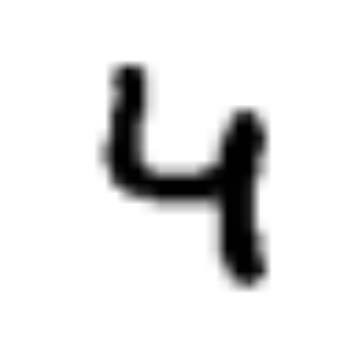

In [23]:
# output random test image and prediction
random_idx = choice(range(len(X_test)))
random_img = X_test[random_idx]
display(random_img)

print 'predicted_labels[{0}] => {1}'.format(random_idx, predicted_labels[random_idx])

# save results of test dataset prediction
np.savetxt('../submissions/submission_10000_epochs.csv', np.c_[range(1, len(X_test) + 1), predicted_labels], delimiter=',', header='ImageId,Label', comments='', fmt='%d')

## Exploring the Learned Representation

Let's take a look at the features learned by some of the network's layers.

We plot saliency maps (what the network deems as "important" in the image) for the activations of all filters of the two convolutional layers, "h_conv1" and "h_conv2".

As you can see, the activations on the first convolutional hidden layer good at capturing lines and shadows, and "passing through" all the pixels of the digit (probably for bookkeeping during the computation), whereas the activations on the second convolutional layer seem to be capturing more abstract features like shapes and boundaries.

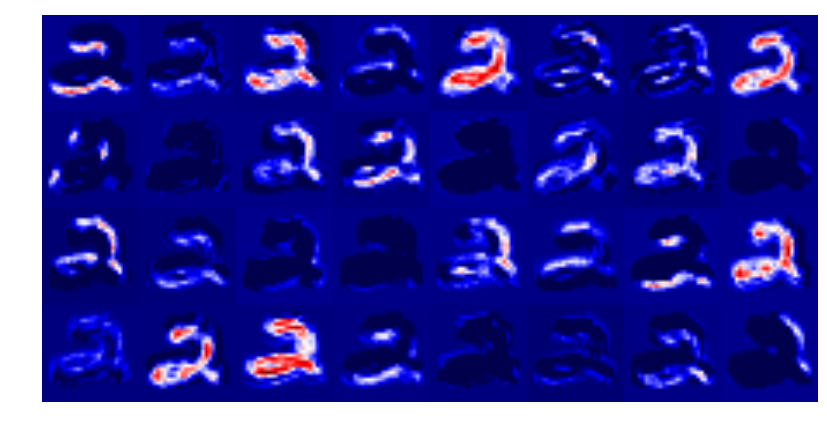

In [44]:
layer1_grid = layer1.eval(feed_dict={x : X_test[0:3], keep_prob : 1.0})
plt.axis('off')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.imshow(layer1_grid[0], cmap=cm.seismic)

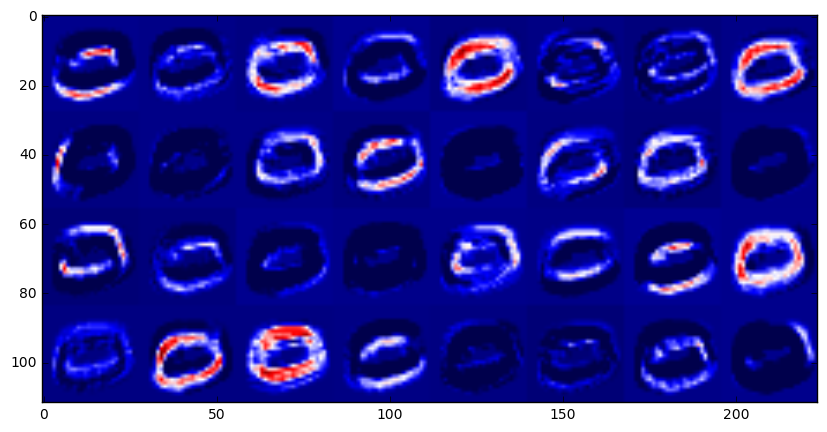

In [45]:
plt.imshow(layer1_grid[1], cmap=cm.seismic)

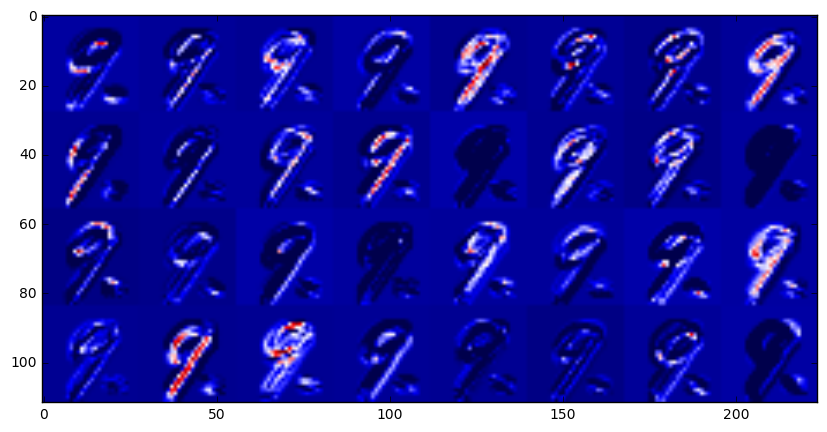

In [46]:
plt.imshow(layer1_grid[2], cmap=cm.seismic)

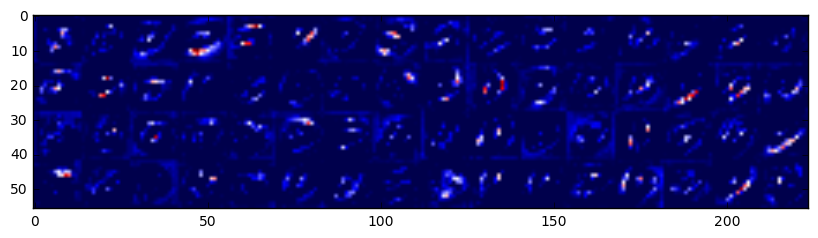

In [48]:
layer2_grid = layer2.eval(feed_dict={x : X_test[3:6], keep_prob : 1.0})
plt.imshow(layer2_grid[0], cmap=cm.seismic)

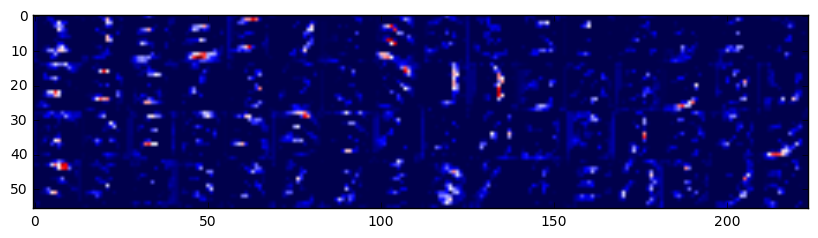

In [49]:
plt.imshow(layer2_grid[1], cmap=cm.seismic)

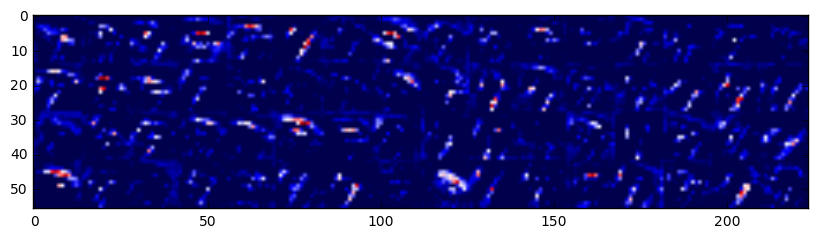

In [50]:
plt.imshow(layer2_grid[2], cmap=cm.seismic)